# Procesamiento De Datos Fotometricos

En este notebook se implementa la obtencion de datos fotometricos del catalago SDSS DR16Q los cuales no se encuentran corregidor, de modo que este notebook busca tambien la limpieza y correcion de estos.

Datos utilizados:

- `Z` : Redshift calculado por SDSS
- `PSFMAG_u`: Magnitud filtro u.
- `PSFMAG_g`: Magnitud filtro g.
- `PSFMAG_r`: Magnitud filtro r.
- `PSFMAG_i`: Magnitud filtro i.
- `SN_MEDIAN_ALL`: Senal a ruido de la medicion.

Lo primero que hacer con los datos corregir la extincion atmosferica 

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo

In [2]:
from astroML.datasets import fetch_sdss_filter

In [3]:
hdul = fits.open("../data/raw/DR16Q_v4.fits", memmap=False)
hdul.info()

Filename: ../data/raw/DR16Q_v4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU    375   750414R x 183C   [18A, D, D, J, J, I, 6A, 6A, I, D, I, D, I, I, I, K, D, I, I, D, I, D, I, D, D, I, D, 12A, D, J, 19A, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, E, 5D, 5D, 5D, E, D, D, D, D, D, D, D, D, K, K, K, K, K, K, J, J, J, 74J, 74J, 74I, 74I, B, J, 3A, J, J, J, D, D, D, D, 14A, J, D, 5E, 5D, 5E, 5D, 5E, D, D, I, D, D, D, D, I, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, I, D, D, D, D, D, D, J, D, D, D, J, D, D, D, J, D, 21A, D, D, E, E, D, K, D, D, E, E, E, E, E, E, E, D, I, 28A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [4]:
header = hdul[1].header
data   = hdul[1].data

In [5]:
def nanomaggies_to_csg (f_nmgy, central_lam) -> float:
    c = 2.99792458e18  # velocidad de la luz en Å/s
    f_nu = f_nmgy * 3.631e-29  # erg/s/cm^2/Hz
    f_lambda = f_nu * c / (central_lam**2)
    return f_lambda

In [6]:
df = pd.DataFrame({
    "Z" : np.array(data["Z"]),
    
    "PSFMAG_u" : np.array(data["PSFMAG"])[:, 0],
    "PSFMAG_g" : np.array(data["PSFMAG"])[:, 1],
    "PSFMAG_r" : np.array(data["PSFMAG"])[:, 2],
    "PSFMAG_i" : np.array(data["PSFMAG"])[:, 3],

    "EXTINCTION_u" : np.array(data["EXTINCTION"])[:, 0],
    "EXTINCTION_g" : np.array(data["EXTINCTION"])[:, 1],
    "EXTINCTION_r" : np.array(data["EXTINCTION"])[:, 2],
    "EXTINCTION_i" : np.array(data["EXTINCTION"])[:, 3],

    "SN_MEDIAN_ALL": np.array(data["SN_MEDIAN_ALL"]),
})

df.head(10)

,Z,PSFMAG_u,PSFMAG_g,PSFMAG_r,PSFMAG_i,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,SN_MEDIAN_ALL
0,0.845435,18.964045,18.630692,18.429541,18.411808,0.343751,0.267848,0.185296,0.137695,24.468967
1,2.035491,22.082529,21.787088,21.562086,21.359495,0.198869,0.154957,0.107199,0.079660,2.288593
2,1.574227,22.517344,22.102839,21.854153,21.637999,0.243944,0.190079,0.131496,0.097716,1.420663
3,1.770552,22.347525,21.903051,21.752844,21.663532,0.263077,0.204988,0.141810,0.105380,1.009057
4,2.024146,18.766439,18.662741,18.499794,18.336531,0.372653,0.290368,0.200875,0.149272,22.831877
5,2.309000,22.440338,21.908857,22.069986,21.926800,0.120217,0.093672,0.064802,0.048155,2.031490
6,0.250000,21.683229,21.194639,20.509224,20.153481,0.174611,0.136056,0.094123,0.069943,7.569236
7,2.102771,22.360628,21.617563,21.339863,21.284025,0.233826,0.182196,0.126042,0.093663,4.392148
8,1.991313,19.681828,19.405962,19.318926,19.036442,0.210684,0.164163,0.113567,0.084393,9.443050
9,2.497000,21.941969,21.223650,20.886095,20.782257,0.163415,0.127332,0.088088,0.065459,4.692556


In [7]:
for c in df.columns: 
    df[c] = df[c].astype(np.float64, copy=False)

# Eliminamos valores fuera de lo comun.
df = df.replace(-9999, np.nan).dropna(subset=["Z","PSFMAG_u","PSFMAG_g","PSFMAG_r","PSFMAG_i","SN_MEDIAN_ALL"])
df = df.query("12 < PSFMAG_u < 30 and 12 < PSFMAG_g < 30 and 12 < PSFMAG_r < 30 and 12 < PSFMAG_i < 30")

In [8]:
# Quitamos los valores que no tengan una senal, redshift muy grandes o mucha extincion galactica
df_clean = df [
    (df["Z"] < 2.5)             & # Z muy grandes pueden generar probleas
    (df["SN_MEDIAN_ALL"] >= 25) & # Buena senal a ruido
    (df["EXTINCTION_r"] < 0.3)    # Sin mucha extioncion
].copy(deep=True)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7298 entries, 195 to 750260
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Z              7298 non-null   float64
 1   PSFMAG_u       7298 non-null   float64
 2   PSFMAG_g       7298 non-null   float64
 3   PSFMAG_r       7298 non-null   float64
 4   PSFMAG_i       7298 non-null   float64
 5   EXTINCTION_u   7298 non-null   float64
 6   EXTINCTION_g   7298 non-null   float64
 7   EXTINCTION_r   7298 non-null   float64
 8   EXTINCTION_i   7298 non-null   float64
 9   SN_MEDIAN_ALL  7298 non-null   float64
dtypes: float64(10)
memory usage: 627.2 KB


In [9]:
# Obtenemos los datos del template
hdul = fits.open("../data/templates/optical_nir_qso_sed_001.fits")

lam = hdul[1].data["WAVELENGTH"]
flx = hdul[1].data["FLUX"]

In [10]:
# Obtenemos los filtros
filters = {}
for f in "ugri":
    filters[f] = fetch_sdss_filter(f)

downloading from http://classic.sdss.org/dr7/instruments/imager/filters/u.dat
downloading from http://classic.sdss.org/dr7/instruments/imager/filters/g.dat
downloading from http://classic.sdss.org/dr7/instruments/imager/filters/r.dat
downloading from http://classic.sdss.org/dr7/instruments/imager/filters/i.dat


In [11]:
def kr_correction (lam, filter_lam, filter_thr, spect_flx, z):
    # Valores del filtro interpolado
    R0 = np.interp(lam,       filter_lam, filter_thr, left=0.0, right=0.0)
    Rz = np.interp((1+z)*lam, filter_lam, filter_thr, left=0.0, right=0.0)

    # Integrales con el factor λ (fotones)
    num = np.trapezoid(spect_flx * Rz * lam, lam)
    den = np.trapezoid(spect_flx * R0 * lam, lam)

    # K-correction (misma banda)
    K = -2.5 * np.log10((1.0 + z) * (num / den))
    
    return float(K)

In [12]:
z = pd.to_numeric(df_clean["Z"], errors="coerce").astype(float).values

# Máscara válida: real, finito y z >= 0
mask = np.isfinite(z) & (z >= 0)

# Calcula DM solo donde es válido
dm = np.full(z.shape, np.nan, dtype=float)
dm[mask] = cosmo.distmod(z[mask]).value  # mag

df_clean["DM"] = dm

In [13]:
df_clean["K_u"] = np.array([kr_correction(lam, filters['u'][0], filters['u'][1], flx, z) for z in df_clean["Z"]])
df_clean["K_g"] = np.array([kr_correction(lam, filters['g'][0], filters['g'][1], flx, z) for z in df_clean["Z"]])
df_clean["K_r"] = np.array([kr_correction(lam, filters['r'][0], filters['r'][1], flx, z) for z in df_clean["Z"]])
df_clean["K_i"] = np.array([kr_correction(lam, filters['i'][0], filters['i'][1], flx, z) for z in df_clean["Z"]])

In [14]:
df_clean["M_u"] = df_clean["PSFMAG_u"] - df_clean["EXTINCTION_u"] - df_clean["DM"] - df_clean["K_u"]
df_clean["M_g"] = df_clean["PSFMAG_g"] - df_clean["EXTINCTION_g"] - df_clean["DM"] - df_clean["K_g"] 
df_clean["M_r"] = df_clean["PSFMAG_r"] - df_clean["EXTINCTION_r"] - df_clean["DM"] - df_clean["K_r"]
df_clean["M_i"] = df_clean["PSFMAG_i"] - df_clean["EXTINCTION_i"] - df_clean["DM"] - df_clean["K_i"]

In [15]:
df_clean["u_g"] = df_clean["M_u"] - df_clean["M_g"]
df_clean["g_r"] = df_clean["M_g"] - df_clean["M_r"]
df_clean["r_i"] = df_clean["M_r"] - df_clean["M_i"]

C:\Users\jm_ra\AppData\Local\Temp\ipykernel_18832\1180755831.py:28: UserWarning: Glyph 8333 (\N{SUBSCRIPT LEFT PARENTHESIS}) missing from font(s) Arial.
  plt.savefig("../results/figures/color-magnitud.png")
C:\Users\jm_ra\AppData\Local\Temp\ipykernel_18832\1180755831.py:28: UserWarning: Glyph 8334 (\N{SUBSCRIPT RIGHT PARENTHESIS}) missing from font(s) Arial.
  plt.savefig("../results/figures/color-magnitud.png")
c:\Users\jm_ra\Documents\Proyectos\network_analisis\DR16Q\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8333 (\N{SUBSCRIPT LEFT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jm_ra\Documents\Proyectos\network_analisis\DR16Q\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8334 (\N{SUBSCRIPT RIGHT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


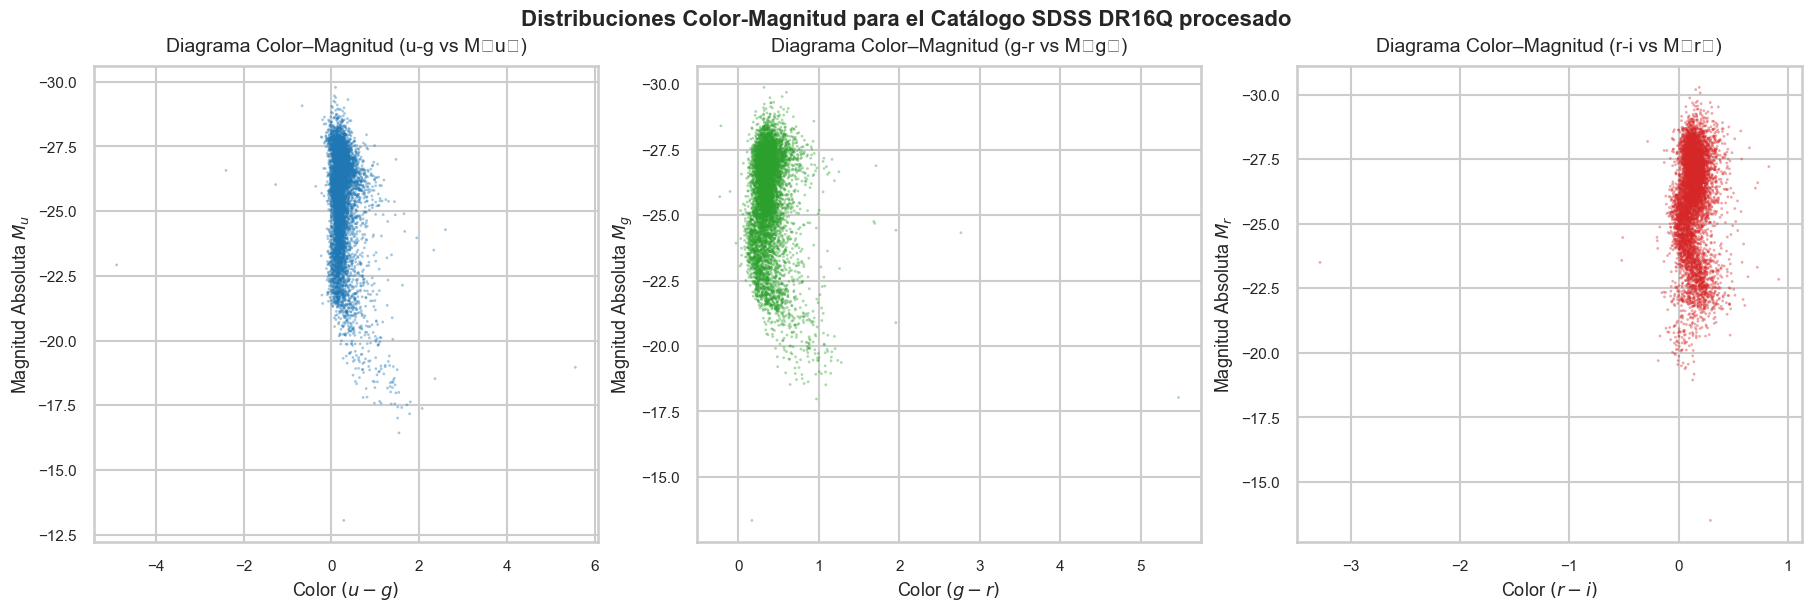

In [21]:
sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

colors = ["#1f77b4", "#2ca02c", "#d62728"]

ax[0].scatter(df_clean["u_g"], df_clean["M_u"], s=4, alpha=0.4, color=colors[0], edgecolor="none")
ax[0].set_xlabel(r"Color $(u - g)$", fontsize=13)
ax[0].set_ylabel(r"Magnitud Absoluta $M_u$", fontsize=13)
ax[0].set_title("Diagrama Color–Magnitud (u-g vs M₍u₎)", fontsize=14, pad=10)

ax[1].scatter(df_clean["g_r"], df_clean["M_g"], s=4, alpha=0.4, color=colors[1], edgecolor="none")
ax[1].set_xlabel(r"Color $(g - r)$", fontsize=13)
ax[1].set_ylabel(r"Magnitud Absoluta $M_g$", fontsize=13)
ax[1].set_title("Diagrama Color–Magnitud (g-r vs M₍g₎)", fontsize=14, pad=10)

ax[2].scatter(df_clean["r_i"], df_clean["M_r"], s=4, alpha=0.4, color=colors[2], edgecolor="none")
ax[2].set_xlabel(r"Color $(r - i)$", fontsize=13)
ax[2].set_ylabel(r"Magnitud Absoluta $M_r$", fontsize=13)
ax[2].set_title("Diagrama Color–Magnitud (r-i vs M₍r₎)", fontsize=14, pad=10)

for a in ax:
    a.invert_yaxis()
    a.tick_params(axis='both', which='major', labelsize=11)

fig.suptitle("Distribuciones Color-Magnitud para el Catálogo SDSS DR16Q procesado", fontsize=16, weight='bold')

plt.savefig("../results/figures/color-magnitud.png")


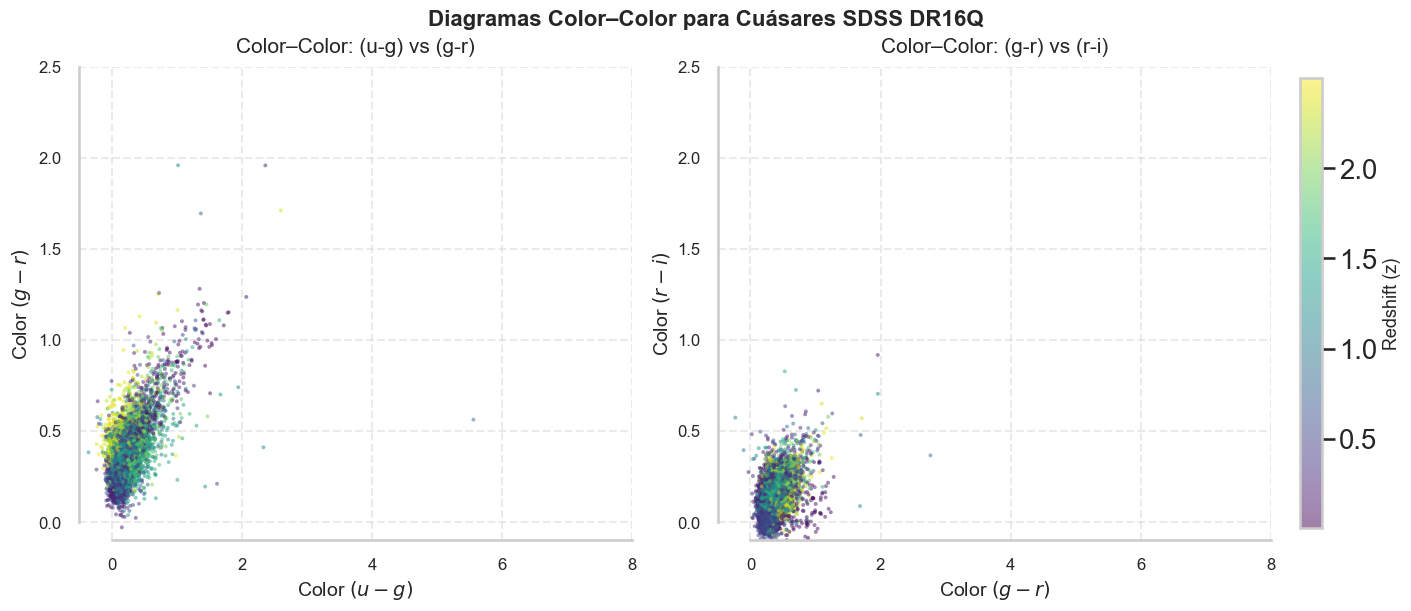

In [22]:
sns.set_theme(style="whitegrid", context="talk", font_scale=1.2)

fig, ax = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

sc1 = ax[0].scatter(df_clean["u_g"], df_clean["g_r"], c=df_clean["Z"], cmap="viridis", s=8, alpha=0.5, edgecolor="none")
ax[0].set_xlabel(r"Color $(u - g)$", fontsize=14)
ax[0].set_ylabel(r"Color $(g - r)$", fontsize=14)
ax[0].set_title("Color–Color: (u-g) vs (g-r)", fontsize=15, pad=10)
ax[0].grid(True, linestyle="--", alpha=0.4)
ax[0].set_xlim(-0.5, 8)
ax[0].set_ylim(-0.1, 2.5)

sc2 = ax[1].scatter(df_clean["g_r"], df_clean["r_i"], c=df_clean["Z"], cmap="viridis", s=8, alpha=0.5, edgecolor="none")
ax[1].set_xlabel(r"Color $(g - r)$", fontsize=14)
ax[1].set_ylabel(r"Color $(r - i)$", fontsize=14)
ax[1].set_title("Color–Color: (g-r) vs (r-i)", fontsize=15, pad=10)
ax[1].grid(True, linestyle="--", alpha=0.4)
ax[1].set_xlim(-0.5, 8)
ax[1].set_ylim(-0.1, 2.5)

cbar = fig.colorbar(sc2, ax=ax.ravel().tolist(), shrink=0.95, pad=0.02)
cbar.set_label("Redshift (z)", fontsize=13)

for a in ax:
    a.tick_params(axis="both", labelsize=12)
    sns.despine(ax=a, trim=True)

fig.suptitle("Diagramas Color–Color para Cuásares SDSS DR16Q", fontsize=16, weight="bold")
plt.savefig("../results/figures/color-color.png")

C:\Users\jm_ra\AppData\Local\Temp\ipykernel_18832\3251293863.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


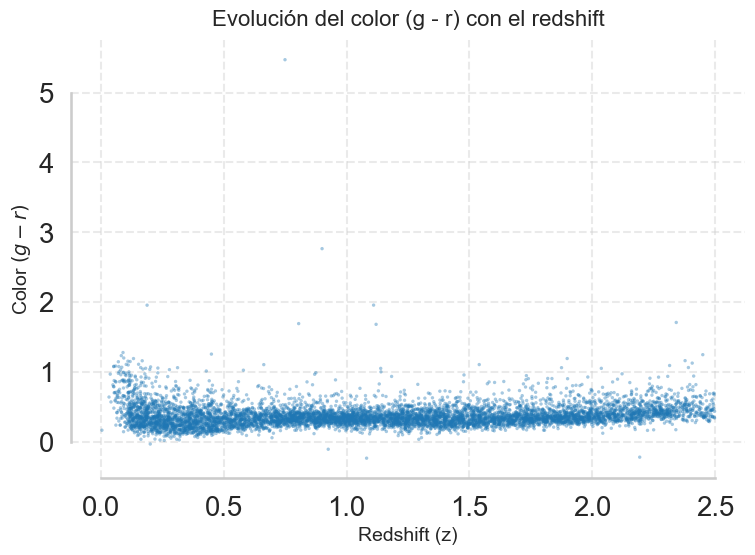

In [25]:
sns.set_theme(style="whitegrid", context="talk", font_scale=1.2)

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter semitransparente
ax.scatter(df_clean["Z"], df_clean["g_r"], s=6, alpha=0.4, color="#1f77b4", edgecolor="none")

# Etiquetas y estilo
ax.set_xlabel("Redshift (z)", fontsize=14)
ax.set_ylabel(r"Color $(g - r)$", fontsize=14)
ax.set_title("Evolución del color (g - r) con el redshift", fontsize=16, pad=10)
ax.legend(frameon=False)

ax.grid(True, linestyle="--", alpha=0.4)
sns.despine(trim=True)

plt.tight_layout()
plt.savefig("../results/figures/color-redshift.png")

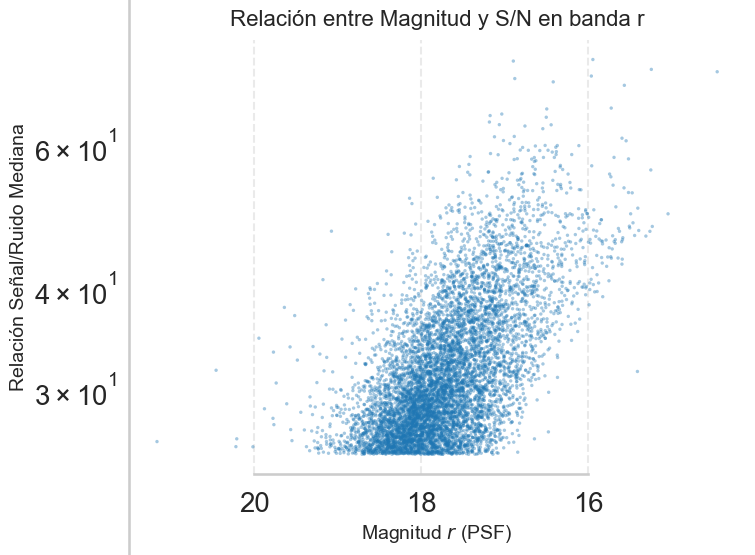

In [26]:
sns.set_theme(style="whitegrid", context="talk", font_scale=1.2)

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter de puntos
ax.scatter(df_clean["PSFMAG_r"], df_clean["SN_MEDIAN_ALL"],
           s=6, alpha=0.4, color="#1f77b4", edgecolor="none")

# Etiquetas y estilo
ax.set_xlabel(r"Magnitud $r$ (PSF)", fontsize=14)
ax.set_ylabel("Relación Señal/Ruido Mediana", fontsize=14)
ax.set_title("Relación entre Magnitud y S/N en banda r", fontsize=16, pad=10)

# Escala y límites
ax.invert_xaxis()  # magnitudes: brillante → izquierda
ax.set_yscale("log")  # opcional, muestra mejor el rango dinámico

# Estilo visual
ax.grid(True, linestyle="--", alpha=0.4)
sns.despine(trim=True)
plt.tight_layout()
plt.savefig("../results/figures/mag_sn.png")

In [20]:
df_clean.to_csv("../data/processed/photometric_z2.5_sn_25.csv", index=False)